In [27]:
## Standard imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import json
import torch
import astroddpm
import tqdm.notebook as tqdm

In [28]:
from astroddpm.diffusion.models.network import DownResBlock, MidResBlock, NormConv2d, sinusoidal_embedding, gaussian_fourier_embedding, SineCosine
from torch.nn import functional as F
from torch import nn

In [29]:
## Relative imports
from astroddpm.runners import config_from_id
from astroddpm.diffusion.stochastic.sde import DiscreteVPSDE, ContinuousVPSDE
import astroddpm.utils.colormap_custom 
from astroddpm.datahandler.dataset import get_dataset_and_dataloader
from astroddpm.diffusion.stochastic.sde import get_sde
from astroddpm.diffusion.power_spectra.powerspec_sampler import get_ps_sampler
from astroddpm.utils.scheduler import CosineAnnealingScheduler, LinearScheduler, InversePowerLawScheduler, InverseSquareRootScheduler, StepScheduler

In [30]:
from astroddpm.moment.models import TparamMomentNetwork, MomentModel

In [31]:
ALL_MODELS = os.path.join(os.path.dirname(astroddpm.__file__), 'config', 'MODELS.json')

with open(ALL_MODELS, 'r') as f:
    ALL_MODELS_DICT = json.load(f)

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
amin = - 3
amax = 6

diffuser_ID = 'ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_16_firstc_6_phi_beta_cosine'

In [33]:
config = config_from_id(diffuser_ID)

In [34]:
config.keys()

dict_keys(['diffusion_model', 'dataloaders', 'optimizer', 'scheduler', 'ckpt_epoch', 'separate_ckpt', 'ckpt_dir', 'sample_epoch', 'sample_dir', 'sample_size', 'results_size', 'epochs', 'model_id'])

In [35]:
dataloaders_config = config['dataloaders']
power_spectrum_config = config['diffusion_model']['ps']
sde_config = config['diffusion_model']['sde']

In [36]:
train_dataset, test_dataset, train_dataloader, test_dataloader = get_dataset_and_dataloader(dataloaders_config)
ps_sampler = get_ps_sampler(power_spectrum_config)
sde = get_sde(sde_config)
sde.beta_0 = 0.01
sde.beta_T = 0.5
sde.noise_level(torch.ones(1))

tensor([0.5389])

In [37]:
def train(model, optimizer, train_dataloader, epochs,test_dataloader = None, ckpt_path = None, ckpt_step = 5, scheduler = None):
    train_losses = []
    test_losses = []
    progress_bar = tqdm.tqdm(range(epochs))
    if model.conetwork is not None:
        for param in model.conetwork.parameters():
            param.requires_grad_(False)
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            if len(batch.shape) == 3:
                batch = batch.unsqueeze(1)
            batch = batch.to(device)
            optimizer.zero_grad()
            loss = model.loss(batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)
        if test_dataloader is not None:
            model.eval()
            test_loss = 0
            for batch in test_dataloader:
                if len(batch.shape) == 3:
                    batch = batch.unsqueeze(1)
                batch = batch.to(device)
                loss = model.loss(batch)
                test_loss += loss.item()
            test_loss /= len(test_dataloader)
            test_losses.append(test_loss)
        log = "Epoch {} | Train loss: {:2f} | Test loss: {:2f}".format(epoch, train_loss, test_loss)
        if scheduler is not None:
            scheduler.step()
        progress_bar.update(1)
        progress_bar.set_description(log)
        if ckpt_path is not None and (epoch % ckpt_step == 0):
            ckpt = {"model": model.state_dict(), "optimizer": optimizer.state_dict(), "epoch": epoch, "config": model.config}
            torch.save(ckpt, os.path.join(ckpt_path, f"ckpt.pt"))
    if model.conetwork is not None:
        for param in model.conetwork.parameters():
            param.requires_grad_(True)
    return train_losses, test_losses

In [38]:
CKPT_PATH = '/mnt/home/dheurtel/ceph/02_checkpoints'
MODEL_ID = 'MomentModel_ContinuousVPSDE_I_BPROJ_beta_0_0.01_beta_T_0.5_beta_schedule_cosine'

CKPT_DIR = os.path.join(CKPT_PATH, MODEL_ID)
os.makedirs(CKPT_DIR, exist_ok=True)

In [39]:
l = os.listdir(CKPT_PATH)
l = [x for x in l if x.startswith('Moment')]
l

['MomentModel_ContinuousVPSDE_I_BPROJ_smallnoise',
 'MomentModel_ContinuousVPSDE_I_BPROJ',
 'MomentModel_ContinuousVPSDE_I_BPROJ_beta_0_0.01_beta_T_0.5_beta_schedule_cosine']

In [40]:
load_ckpt = True

if load_ckpt:
    ckpt = torch.load(os.path.join(CKPT_DIR, 'ckpt.pt'))
    config = ckpt['config']
    state_dict = ckpt['model']

In [41]:
config.keys()

dict_keys(['network', 'sde', 'ps', 'order', 'exp_matr'])

In [42]:
if load_ckpt:
    network = TparamMomentNetwork(**config['network'])

    network = network.to(device)
else:
    network = TparamMomentNetwork( in_channels = 1, dim_param = 2, in_size = 256, order = 1, num_blocks = 3, first_channels = 10, time_embed_dim = 100,padding_mode="circular", 
             normalize="GN", group_c=1, skiprescale = True, discretization = "continuous", embedding_mode = None, n_steps = 1000,dropout=0.0)
    network = network.to(device)

In [43]:
model = MomentModel(network, sde, ps_sampler)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

if load_ckpt:
    model.load_state_dict(state_dict)
    optimizer.load_state_dict(ckpt['optimizer'])

model= model.to(device)

In [44]:
epochs = 0 

In [45]:
train_losses, test_losses = train(model, optimizer, train_dataloader, epochs= 800,test_dataloader = test_dataloader, ckpt_path = CKPT_DIR, ckpt_step = 5)

  0%|          | 0/800 [00:00<?, ?it/s]

KeyboardInterrupt: 

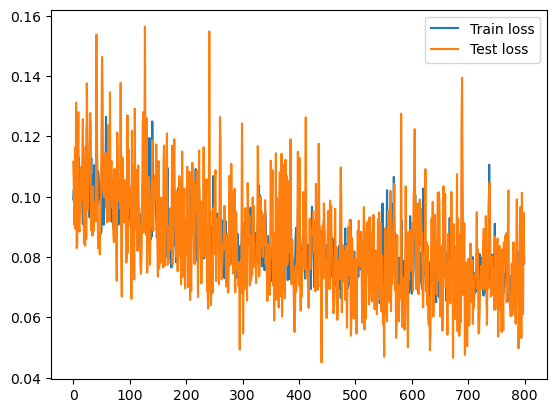

In [ ]:
## Plot the losses

plt.plot(train_losses, label = "Train loss")
plt.plot(test_losses, label = "Test loss")
plt.legend()
plt.show()

In [46]:
## Plot a few guesses.

model.eval()
rphi_list = []
out_list = []
for _ in range(30):
    with torch.no_grad():
        batch = next(iter(test_dataloader))
        batch = batch.to(device)
        noise_level = 0.1
        T = sde.get_closest_timestep(noise_level)
        if len(batch.shape) == 3:
            batch = batch.unsqueeze(1)
        timesteps = T.repeat(batch.shape[0],1).to(device)
        #ps_tensor, phi = ps_sampler.sample_ps(batch.shape[0])
        #batch_tilde, _ , _ = sde.sampling(batch, timesteps, torch.sqrt(ps_tensor))
        #rphi = ps_sampler.rescale_phi(phi)
        rphi = torch.rand(batch.shape[0],2).to(device)*2 - 1
        phi = ps_sampler.unscale_phi(rphi)
        ps_tensor = ps_sampler(phi)
        batch_tilde, _ , _ = sde.sampling(batch, timesteps, torch.sqrt(ps_tensor))
        out = model.network(batch_tilde, timesteps)
        residual = (out - rphi).cpu()
        out = out.cpu()
        rphi = rphi.cpu()
        rphi_list.append(rphi)
        out_list.append(out)

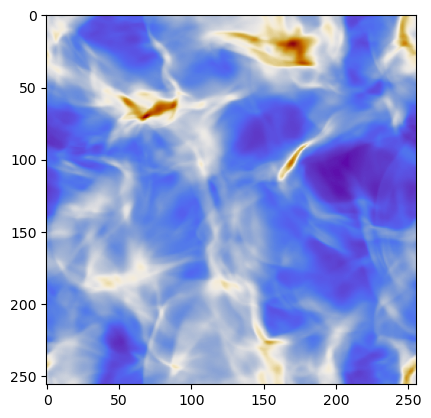

In [47]:
plt.imshow(batch[0,0].cpu(), cmap='cmb')

In [48]:
all_rphi = torch.cat(rphi_list, dim=0)
all_out = torch.cat(out_list, dim=0)

all_residual = all_out - all_rphi

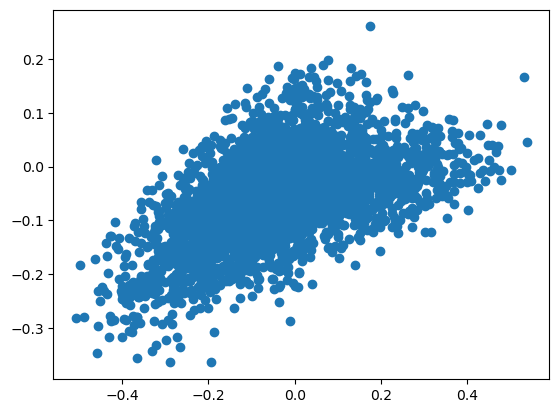

In [49]:
plt.scatter(all_residual[:,0], all_residual[:,1])
plt.show()

Text(0, 0.5, '$\\hat \\Omega$')

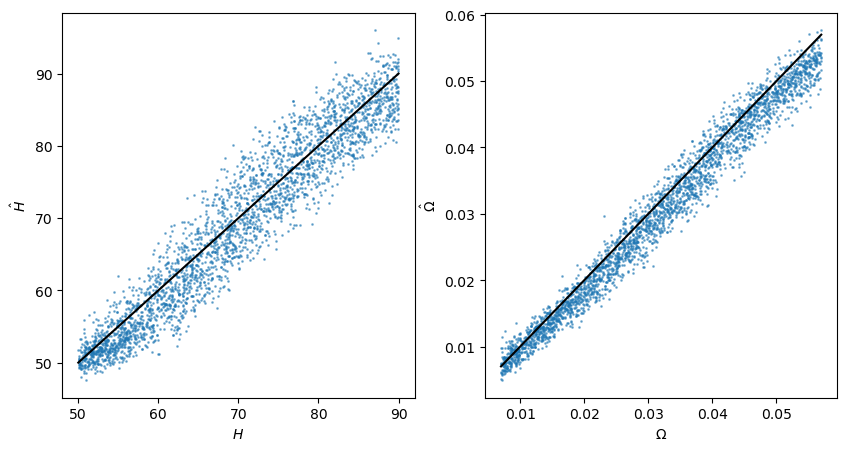

In [50]:
## Plot the empirical cdf for rphi and out
fig, ax = plt.subplots(1,2, figsize=(10,5))

phi  = model.ps.unscale_phi(all_rphi.to(device)).cpu()
true_out = model.ps.unscale_phi(all_out.to(device)).cpu()
## Plot with small size and med alpha
ax[0].scatter(phi[:,0], true_out[:,0], s=1, alpha=0.5)
ax[0].plot([50,90],[50,90], color="black")
ax[0].set_xlabel("$H$")
ax[0].set_ylabel("$\hat H$")
omega_min, omega_max = phi[:,1].min(), phi[:,1].max()
ax[1].scatter(phi[:,1], true_out[:,1], s=1, alpha=0.5)
ax[1].plot([omega_min,omega_max],[omega_min,omega_max], color="black")
ax[1].set_xlabel("$\Omega$")
ax[1].set_ylabel("$\hat \Omega$")


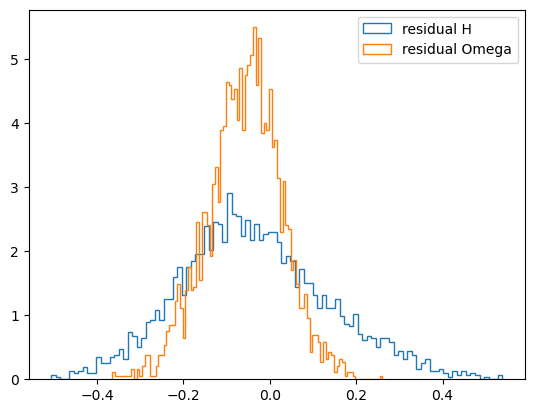

In [51]:
plt.hist(all_residual[:,0], bins = 100, density = True, histtype = "step", label = "residual H")
plt.hist(all_residual[:,1], bins = 100, density = True, histtype = "step", label = "residual Omega")
plt.legend()
plt.show()

In [1]:
## Train a second order model

network2 = TparamMomentNetwork( in_channels = 1, dim_param = 2, in_size = 32, order = 2, num_blocks = 3, first_channels = 10, time_embed_dim = 100,padding_mode="circular", 
         normalize="GN", group_c=1, skiprescale = True, discretization = "continuous", embedding_mode = None, n_steps = 1000,dropout=0.0)

network2 = network2.to(device)

NameError: name 'TparamMomentNetwork' is not defined

In [100]:
model2 = MomentModel(network2, sde, ps_sampler, conetwork = network)

optimizer2 = torch.optim.AdamW(model2.parameters(), lr=1e-3)

epochs = 1200

In [101]:
train_losses2, test_losses2 = train(model2, optimizer2, train_dataloader, epochs = 400,test_dataloader = test_dataloader, ckpt_path = CKPT_DIR, ckpt_step = 5)

  0%|          | 0/400 [00:00<?, ?it/s]

KeyboardInterrupt: 

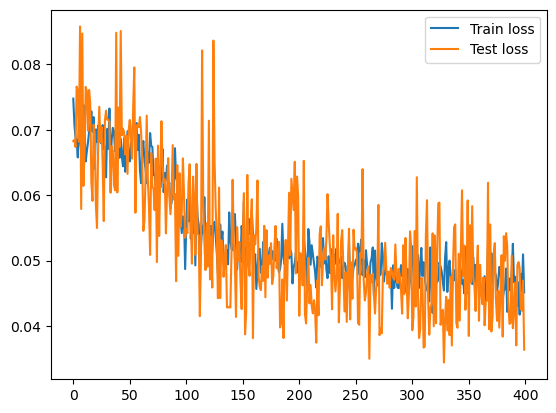

In [74]:
## Plot the losses

plt.plot(train_losses2, label = "Train loss")
plt.plot(test_losses2, label = "Test loss")
plt.legend()

In [226]:
rphi_0_grid = torch.linspace(-1, 1, 10)
rphi_1_grid = torch.linspace(-1, 1, 10)

rphi_0_grid, rphi_1_grid = torch.meshgrid(rphi_0_grid, rphi_1_grid)

rphi_grid = torch.stack([rphi_0_grid, rphi_1_grid], dim = -1)

In [227]:
rphi_grid = rphi_grid.reshape(-1,2)

In [228]:
rphi_grid_list = rphi_grid.split(1)

In [249]:
model.eval()
rphi_0_grid = torch.linspace(-1, 1, 10)
results = []
for rphi_0 in rphi_0_grid:
    with torch.no_grad():
        batch = next(iter(test_dataloader))
        batch = batch.to(device)
        noise_level = 0.1
        T = sde.get_closest_timestep(noise_level)
        if len(batch.shape) == 3:
            batch = batch.unsqueeze(1)
        timesteps = T.repeat(batch.shape[0],1).to(device)
        rphi_test = torch.tensor([rphi_0, 0.0]).to(device).reshape(1,2).repeat(batch.shape[0],1)
        phi_test = ps_sampler.unscale_phi(rphi_test)
        ps_test = ps_sampler(phi_test)
        batch_tilde, _ , _ = sde.sampling(batch, timesteps, torch.sqrt(ps_test))
        out = model.network(batch_tilde, timesteps)
        results.append(out.cpu().detach().numpy())
        residual = (out - rphi_test).cpu()

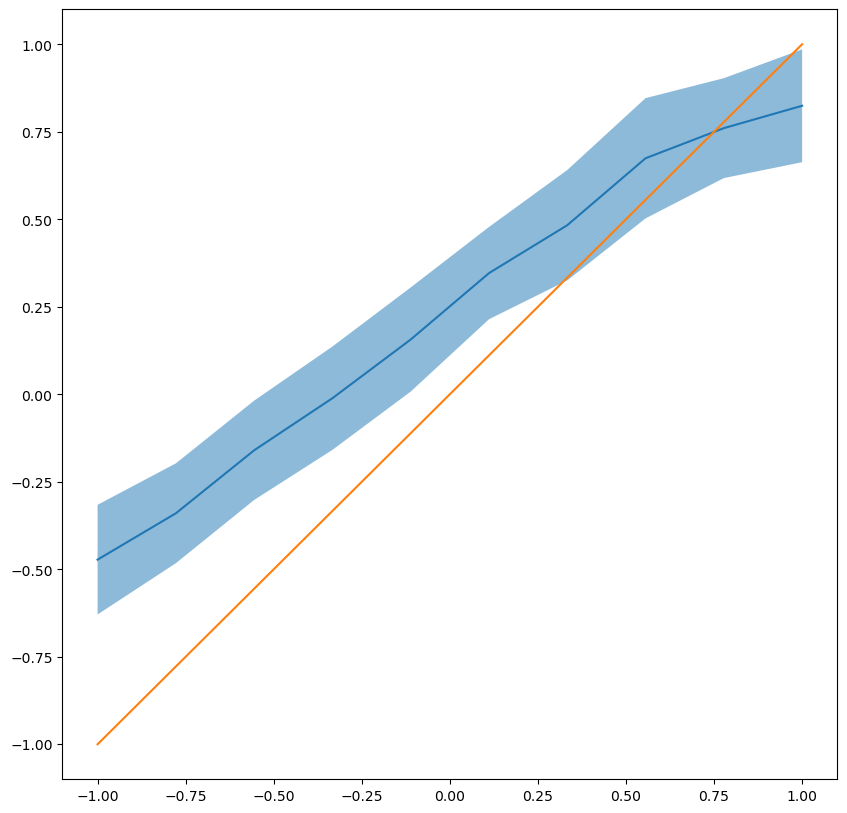

In [250]:
## Plot the results. Plot the mean of the model as a function of the true mean (for rphi_0)

fig, ax = plt.subplots(figsize = (10,10))

results = [res.reshape(1,100,2) for res in results]
results = np.concatenate(results, axis = 0)

ax.plot(rphi_0_grid, results[:, :, 0].mean(axis = 1), label = "Model mean")
ax.fill_between(rphi_0_grid, results[:, :, 0].mean(axis = 1) - results[:, :, 0].std(axis = 1), results[:, :, 0].mean(axis = 1) + results[:, :, 0].std(axis = 1), alpha = 0.5)
ax.plot(rphi_0_grid, rphi_0_grid, '-' ,label = "True mean")

In [116]:
## Sample one phi, build some noisy x and compute the estimated mean and covariance matrix of the posterior given x

model.eval()
model2.eval()

with torch.no_grad():
    batch = next(iter(test_dataloader))
    batch = batch.to(device)
    noise_level = 0.02
    T = sde.get_closest_timestep(noise_level)
    if len(batch.shape) == 3:
        batch = batch.unsqueeze(1)
    timesteps = T.repeat(batch.shape[0],1).to(device)
    ps_tensor, phi = ps_sampler.sample_ps(batch.shape[0])
    batch_tilde, _ , _ = sde.sampling(batch, timesteps, torch.sqrt(ps_tensor))
    rphi = ps_sampler.rescale_phi(phi)
    mean = model.network(batch_tilde, timesteps)
    cov = model2.network(batch_tilde, timesteps)
rphi = rphi.cpu()
mean = mean.cpu()
cov = cov.cpu()

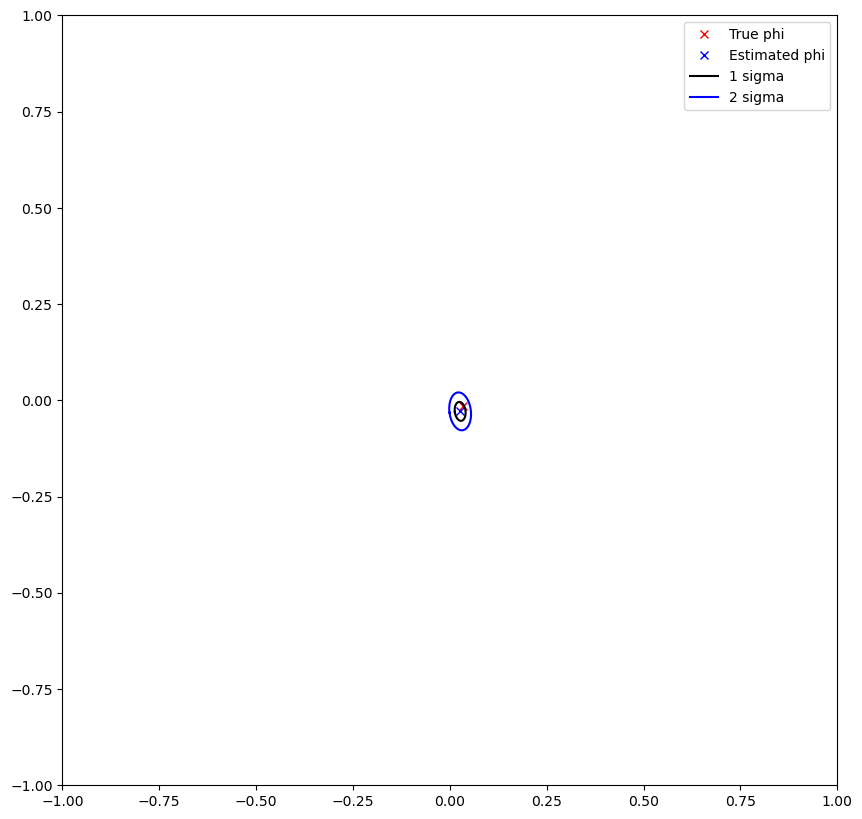

In [117]:
idx = 0

## Plot a 2D image with a red cross at the true value of phi and a blue cross at the estimated value of phi and two ellipses corresponding to 1 sigma and 2 sigma confidence intervals
fig, ax = plt.subplots(1,1, figsize = (10,10))
ax.plot(rphi[idx,0], rphi[idx,1], 'rx', label = "True phi")
ax.plot(mean[idx,0], mean[idx,1], 'bx', label = "Estimated phi")

## Get the points to plot the ellipses
thetas = np.linspace(0, 2*np.pi, 100)
x = np.cos(thetas)
y = np.sin(thetas)
points = np.vstack((x,y)).T

## Compute the eigenvalues and eigenvectors of the covariance matrix

eigvals, eigvecs = np.linalg.eig(cov[idx].cpu().numpy())

## Plot the 1 sigma ellipse

ellipse = np.sqrt(eigvals[0])*np.outer(points[:,0], eigvecs[:,0]) + np.sqrt(eigvals[1])*np.outer(points[:,1], eigvecs[:,1])
ax.plot(ellipse[:,0] + mean[idx,0].item(), ellipse[:,1] + mean[idx,1].item(), 'black', label = "1 sigma")

## Plot the 2 sigma ellipse

ellipse = 2*np.sqrt(eigvals[0])*np.outer(points[:,0], eigvecs[:,0]) + 2*np.sqrt(eigvals[1])*np.outer(points[:,1], eigvecs[:,1])
ax.plot(ellipse[:,0] + mean[idx,0].item(), ellipse[:,1] + mean[idx,1].item(), 'b', label = "2 sigma")
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
plt.legend()